In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import time
import json
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Check if there is GPU(s): {torch.cuda.is_available()}")

Check if there is GPU(s): True


In [3]:
from src import FogDataloader as fog
from src import SparkMET as sm
from src import models, engine

### Data Generation 
#### This is unique to the preject 

In [4]:
Exp_name = 'test'
SaveDir  = '/data1/fog/SparkMET/EXPs/'

FogDataConfigs = fog.FogData_Configs(input_path      = None, 
                                     target_path     = None, 
                                     start_date      = fog.year_information['2020'][0], 
                                     finish_date     = fog.year_information['2020'][1], 
                                     data_split_dict = fog.data_split_dict_[0], 
                                     data_straucture = '4D',
                                     lead_time_pred  = 24, 
                                     vis_threshold   = 1, 
                                     points_coords   = fog.NAM_coords,  
                                     predictor_names = fog.NETCDF_PREDICTOR_NAMES['All']).return_config()


data_loader_training, data_loader_validate, data_loader_testing = fog.Fog_DataLoader(FogDataConfigs,
                                                                                     batch_size = 32, 
                                                                                     WeightR    = False, 
                                                                                     SaveDir    = SaveDir, 
                                                                                     Exp_name   = Exp_name)



#================================ Summary of Dataset ==================#
number of training samples:   52 | number of training fog cases:   7
number of validation samples: 52 | number of validation fog cases: 7
number of test samples:       52 | number of test fog cases:       7
#======================================================================#


### Model Compiling 

In [5]:
# Emb_2D_SP_Patch, Emb_2D_Patch, Emb_2D_Channel
SparkMET_Config = sm.SparkMET_Configs(img_size =32, in_channel = 388, in_time = 4, 
                          embd_size =1024, num_heads = 8, num_layers = 6, 
                          FactType = 'Emb_2D_SP_Patch').return_config()

In [6]:
SparkMET_Obj = sm.SparkMET(SparkMET_Config, SaveDir = SaveDir, Exp_Name = Exp_name) 
model, optimizer, loss_func = SparkMET_Obj.compile(optmizer = 'adam', loss = 'NLLLoss', lr = 0.0001, wd = 0.01)

Epoch 001: | Train Loss: 0.4861 | Val Loss: 0.1530 | Time(s): 33.226
Best model Saved! Val Loss: 0.1530
count: 0
Epoch 002: | Train Loss: 0.1720 | Val Loss: 0.1071 | Time(s): 32.238
Best model Saved! Val Loss: 0.1071
count: 0


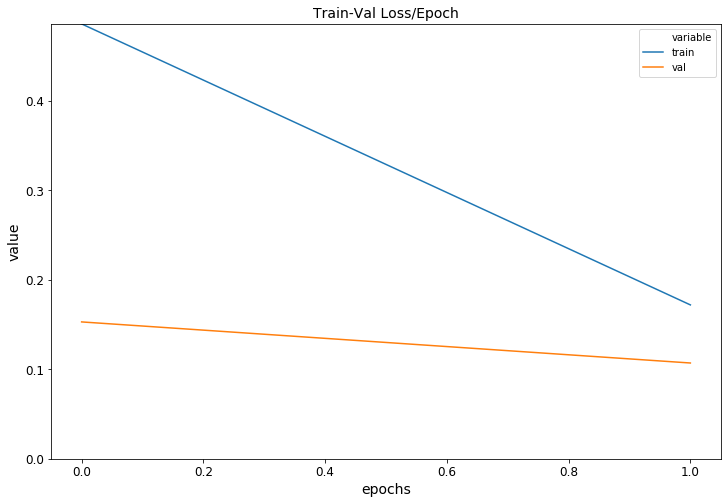

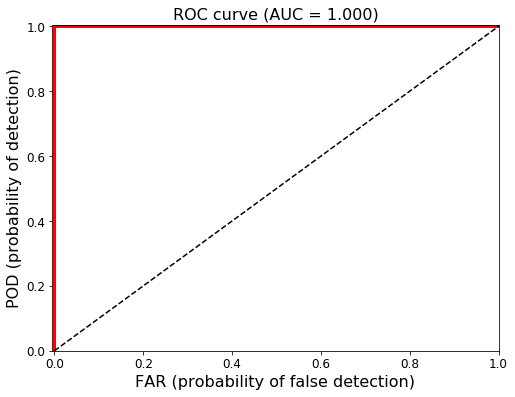

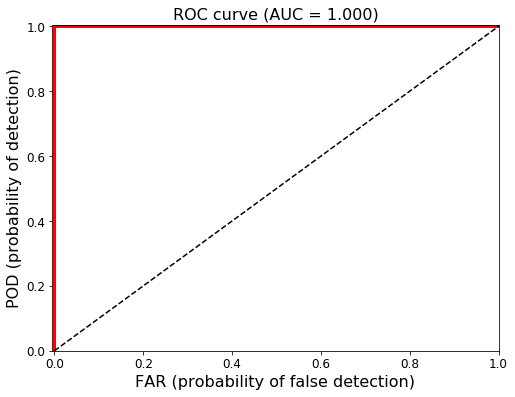

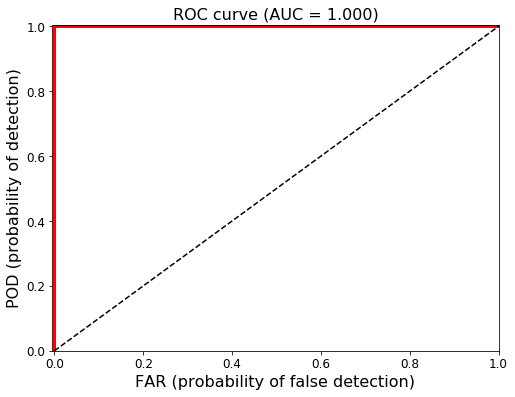

In [7]:
model, loss_stat = SparkMET_Obj.train(model, optimizer, loss_func, 
                                      data_loader_training, 
                                      data_loader_validate, epochs = 2, early_stop_tolerance = 50)

list_outputs     = SparkMET_Obj.predict(model, data_loader_training, data_loader_validate, data_loader_testing)